# Testing among decision tree, random fern and random forest

In [6]:
import numpy as np #Generate random data
import matplotlib.pyplot as plt #Visualisation
import sklearn #Tree algorithms
import pandas as pd

In [31]:
# Generate 500 data with dimension 10 here, output is determined by sign of sum
mean = [20,10,0,-10,-20]
sigma = [4,9]
Data = np.zeros((500,11))

for i in range(5):
    for j in range(2):
        Data[:,2*i+j] = np.random.normal(mean[i],sigma[j],500)

for i in range(500):
    if np.sum(Data[i,0:10]) > 0:
        Data[i,10] = True
    else:
        Data[i,10] = False

In [32]:
# Collect the data as a dataframe
col = []
for i in range(10):
    col.append('feature ' + str(i+1))
col.append('output')
df = pd.DataFrame(Data,columns=col)
df.index += 1

df.head()

,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,feature 9,feature 10,output
1,16.042697,29.736279,3.195541,21.775868,-5.122217,15.388098,-7.899598,-0.005542,-17.268739,-20.928140,1.0
2,21.077337,24.935941,10.119073,17.860102,0.004140,-2.664142,-5.647917,1.718855,-23.753028,-21.513533,1.0
3,25.787733,24.972978,6.716913,7.770915,-3.240248,-20.149673,-19.293165,-15.993421,-16.425945,-12.266088,0.0
4,19.015746,15.276480,5.796987,-4.011528,-0.901452,8.089423,-13.298133,-19.489375,-14.763609,-19.088997,0.0
5,22.245742,27.556949,14.153455,13.789078,0.439600,-1.793084,-11.719482,-11.407960,-18.048891,-1.939298,1.0


In [39]:
# Train, test split
from sklearn.model_selection import train_test_split

X = Data[:,0:10]
y = Data[:,10]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

n_train = len(X_train)
n_test = len(X_test)

In [139]:
# Evaluation function of tree/forest in sklearn, return [TP,TN,FP,FN]
def evaluate(model,X_test,y_test,s):
    n_test = len(X_test)
    arr = [0,0,0,0]
    
    if s=='tree':
        pred = model.predict_proba(X_test)
        for i in range(n_test):
            # predict class 0
            if pred[i,0] == 1:
                # TN
                if y_test[i] == 0:
                    arr[1] += 1
                # FN
                else:
                    arr[3] += 1
            # predict class 1
            else:
                # TP
                if y_test[i] == 1:
                    arr[0] += 1
                # FP
                else:
                    arr[2] += 1
    elif s=='forest':
        pred = model.predict(X_test)
        for i in range(n_test):
            # predict class 0
            if pred[i] == 0:
                # TN
                if y_test[i] == 0:
                    arr[1] += 1
                # FN
                else:
                    arr[3] += 1
            # predict class 1
            else:
                # TP
                if y_test[i] == 1:
                    arr[0] += 1
                # FP
                else:
                    arr[2] += 1
    return arr

In [140]:
def metric(v):
    acc = (v[0]+v[1])/(sum(v))
    pre = v[0]/(v[0]+v[2])
    rec = v[0]/(v[0]+v[3])
    F = 2/(1/pre + 1/rec)

    print('Accuracy: %f' % acc)
    print('Precision: %f' % pre)
    print('Recall: %f' % rec)
    print('F score: %f' % F)

## Tree

In [141]:
# Basic tree
from sklearn import tree

bin_tree = tree.DecisionTreeClassifier()
bin_tree.fit(X_train,y_train)

v = evaluate(bin_tree,X_test,y_test,'tree')
metric(v)

Accuracy: 0.846667
Precision: 0.864198
Recall: 0.853659
F score: 0.858896


## Low level random forest

In [142]:
# Low level implementation of random forest:
# Randomly select 3 features, no bootstraping
# Majority vote for output

forest = []
index = []
for i in range(99):
    feature = np.random.randint(0,10,size=3)
    sample = np.random.randint(0,350,size=100)
    X_trim = X_train[:,feature]
    index.append(feature)
    small_tree = tree.DecisionTreeClassifier()
    small_tree.fit(X_trim,y_train)
    
    forest.append(small_tree)

In [143]:
# Classifier
def forest_classifier(forest,index,x):
    n = len(forest)
    vote_0 = 0
    vote_1 = 0
    for i in range(n):
        small_tree = forest[i]
        x_new = x[index[i]].reshape((1,3))
        pred = small_tree.predict_proba(x_new)
        # Predict 0
        if pred[0,0] == 1:
            vote_0 += 1
        else:
            vote_1 += 1
    
    if vote_1 > vote_0:
        return 1
    else:
        return 0

In [144]:
# Evaluation of random forest, return [TP,TN,FP,FN]
def eval_forest(forest,index,X_test,y_test):
    n_test = len(X_test)
    arr = [0,0,0,0]
    for i in range(n_test):
        pred = forest_classifier(forest,index,X_test[i,:])
        # Predict 0
        if pred == 0:
            if y_test[i] == 0:
                arr[1] += 1
            else:
                arr[3] += 1
        # Predict 1
        else:
            if y_test[i] == 1:
                arr[0] += 1
            else:
                arr[2] += 1
    return arr

In [145]:
v = eval_forest(forest, index, X_test, y_test)
metric(v)

Accuracy: 0.853333
Precision: 0.884615
Recall: 0.841463
F score: 0.862500


## High level random forest

In [150]:
# High level random forest
from sklearn.ensemble import RandomForestClassifier

forest_1 = RandomForestClassifier(max_depth=2,random_state=0)
forest_1.fit(X_train,y_train)

v = evaluate(forest_1,X_test,y_test,'forest')
metric(v)

Accuracy: 0.860000
Precision: 0.867470
Recall: 0.878049
F score: 0.872727


## Random ferns

In [185]:
# Low level implementation of 1 random fern
# Fern size 5
# Randomly choose 5 pairs of features for binary test

y_0 = np.where(y_train == 0)
y_1 = np.where(y_train == 1)
I = np.array([y_0,y_1])

In [273]:
# Train a fern, return a dictionary containing indices for binary tests and the prior distributions
# Input: Training set, indices of samples of different classes (stored as a matrix)
def train_fern(X_train,I,S):
    index = [] # indices for binary test
    n_train = len(X_train) # Number of training samples
    n_class = I.shape
    n_class = n_class[0] # Number of class
    dis = np.zeros(shape=(n_class,2**S)) # Distribution of fern
    B = np.zeros(shape=(n_train,1)) # Hashing array
    
    # Build matrix containing results of binary test, and also index array
    for i in range(S):
        f1 = np.random.randint(0,10)
        f2 = np.random.randint(0,10)
        while f2 == f1 or [f2,f1] in index or [f1,f2] in index:
            f2 = np.random.randint(0,10)
        index.append([f1,f2])
        for j in range(n_train):
            # Binary test here
            if X_train[j,f1] > X_train[j,f2]:
                B[j] += 2**i
            else:
                B[j] += 0
    
    # Build distribution
    for i in range(n_class):
        class_index = I[i,0]
        total = len(class_index)
        B_class = B[class_index]
        for j in range(2**S):
            # Assume uniform when small amount of data
            dis[i,j] = (len(np.where(B_class == j)[0])+1)/(total+2**S)
            
    fern = {'index':index, 'distribution':dis}
    return fern

In [285]:
# Fern classifier
# If one fern, need to change to list [fern] first
# Input: ferns (list of ferns), X_test
def fern_classifier(ferns,X_test):
    n_test = len(X_test)
    n_fern = len(ferns)
    n_class = ferns[0]['distribution'].shape
    n_class = n_class[0]
    S = len(ferns[0]['index'])
    B = np.zeros(n_test)
    pred = np.zeros(n_test)
                  
    for i in range(n_test):
        prod = np.ones(n_class)
        for j in range(n_fern):
            index = ferns[j]['index']
            dis = ferns[j]['distribution']
            # Hashing
            for k in range(S):
                if X_test[i,index[k][0]] > X_test[i,index[k][1]]:
                    B[i] += 2**k
            
            # Semi-naive Bayes
            for k in range(n_class):
                prod[k] *= dis[k][int(B[i])]
        
            B[i] = 0
        
        # Prediction
        if prod[1] > prod[0]:
            pred[i] = 1
        else:
            pred[i] = 0
    
    return pred

In [286]:
# Evaluate ferns, return [TP,TN,FP,FN]
def eval_ferns (pred,y_test):
    n_test = len(y_test)
    v = [0,0,0,0]
    for i in range(n_test):
        if pred[i] == 0:
            if y_test[i] == 0:
                v[1] += 1
            else:
                v[3] += 1
        else:
            if y_test[i] == 0:
                v[2] += 1
            else:
                v[0] += 1
    return v

In [287]:
for i in range(3):
    fern = train_fern(X_train,I,4)
    pred = fern_classifier([fern],X_test)
    v = eval_ferns(pred,y_test)
    metric(v)
    print('')

Accuracy: 0.593333
Precision: 0.723404
Recall: 0.414634
F score: 0.527132

Accuracy: 0.586667
Precision: 0.661290
Recall: 0.500000
F score: 0.569444

Accuracy: 0.620000
Precision: 0.598425
Recall: 0.926829
F score: 0.727273



We see that a single fern does not perform well if we does not have intuition behind. Let's try multiple ferns

In [288]:
# Random ferns
# Input: n (number of ferns), S (size of each fern)
def random_ferns_classifier(n,S):
    ferns = []
    for i in range(n):
        fern = train_fern(X_train,I,S)
        ferns.append(fern)
    return ferns

In [296]:
for i in range(5):
    ferns = random_ferns_classifier(25,7)
    pred = fern_classifier(ferns,X_test)
    v = eval_ferns(pred,y_test)
    metric(v)
    print('')

Accuracy: 0.760000
Precision: 0.750000
Recall: 0.841463
F score: 0.793103

Accuracy: 0.740000
Precision: 0.747126
Recall: 0.792683
F score: 0.769231

Accuracy: 0.753333
Precision: 0.752809
Recall: 0.817073
F score: 0.783626

Accuracy: 0.726667
Precision: 0.753086
Recall: 0.743902
F score: 0.748466

Accuracy: 0.766667
Precision: 0.776471
Recall: 0.804878
F score: 0.790419



We see a significant improvements. Let's try to plot error plots of single fern and multiple ferns respectively.

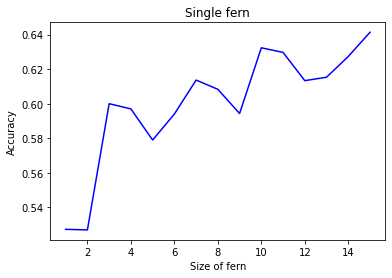

In [311]:
# Accuracy vs size of ferns, average of 20 ferns of each size
# For n >= 18 it runs too slow
n = 15
X = np.arange(1,n+1,1)
y = np.zeros(n)
for i in range(1,n+1):
    for j in range(20):
        fern = train_fern(X_train,I,i)
        pred = fern_classifier([fern],X_test)
        v = eval_ferns(pred,y_test)
        y[i-1] += (v[0]+v[1])/(sum(v)*20)
    
plt.plot(X,y,'b-')

plt.xlabel('Size of fern')
plt.ylabel('Accuracy')
plt.title('Single fern')

plt.show()

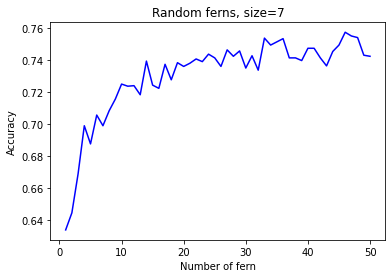

In [313]:
# Accuracy vs number of ferns, size=7, average of 20 ferns of each size
n = 50
X = np.arange(1,n+1,1)
y = np.zeros(n)

for i in range(1,n+1,1):
    for j in range(20):
        ferns = random_ferns_classifier(i,7)
        pred = fern_classifier(ferns,X_test)
        v = eval_ferns(pred,y_test)
        y[i-1] += (v[0]+v[1])/(sum(v)*20)
    
plt.plot(X,y,'b-')

plt.xlabel('Number of fern')
plt.ylabel('Accuracy')
plt.title('Random ferns, size=7')

plt.show()